# Test 1: HRRR + AirNow predicting stations

## HRRR preprocessing

In [1]:
# define bounding box
lat_bottom, lat_top = 33.9, 34.2
lon_bottom, lon_top = -118.4, -118.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5

# date range of data
start_date, end_date = "2025-01-10-00", "2025-01-17-00"

In [2]:
# python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

In [3]:
from libs.hrrrdata import HRRRData
HD_colmd = HRRRData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    extent_name='la_region2',
    product='COLMD',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)

▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 00:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 01:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 02:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 03:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 04:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 05:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 06:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 07:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 08:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 09:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 10:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 11:00 UTC F00 ┊ source=aws
▌▌He

In [4]:
X_hrrr_colmd = HD_colmd.data
print(X_hrrr_colmd.shape)

(165, 5, 200, 200, 1)


In [5]:
HD_mdens = HRRRData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    extent_name='la_region2',
    product='MASSDEN',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)

▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 00:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 01:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 02:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 03:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 04:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 05:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 06:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 07:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 08:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 09:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 10:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 11:00 UTC F00 ┊ source=aws
▌▌He

In [6]:
X_hrrr_mdens = HD_mdens.data
print(X_hrrr_mdens.shape)

(165, 5, 200, 200, 1)


## AirNow preprocessing

In [7]:
# use library to get AirNow data...
'''
from libs.airnowdata import AirNowData
AD = AirNowData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    airnow_api_key=None,
    save_dir='../data/airnow.json',
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../data/interpolation/elevation.npy",
    mask_path="../data/interpolation/no_mask.npy"
)

X_airnow = AD.data
Y = AD.target_stations
'''

# ...or use precomputed AirNow data
import numpy as np

def precomputed_airnow(
    X_path="/home/mgraca/data/precomputed/airnow_features_experiment_1.npy",
    y_path="/home/mgraca/data/precomputed/airnow_target_experiment_1.npy"
):
    X, y = np.load(X_path), np.load(y_path)
    return X, y

In [8]:
X_airnow, Y = precomputed_airnow()
print(X_airnow.shape)
print(Y.shape)

(165, 5, 200, 200, 1)
(165, 3)


## Joint preprocessing
- Split into train/test sets
- Scale train/test sets independently
- Combine X datasets into 1 with 2 channels

In [9]:
# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [10]:
import numpy as np

# split data
X_hrrr_colmd_train, X_hrrr_colmd_test = train_test_split(X_hrrr_colmd, train_size=0.75)
X_hrrr_mdens_train, X_hrrr_mdens_test = train_test_split(X_hrrr_mdens, train_size=0.75)
X_airnow_train, X_airnow_test = train_test_split(X_airnow, train_size=0.75)
y_train, y_test = train_test_split(Y, train_size=0.75)

# scale training data, then test data based on training data's stats
X_hrrr_colmd_train, X_hrrr_colmd_test = std_scale(X_hrrr_colmd_train, X_hrrr_colmd_test)
X_hrrr_mdens_train, X_hrrr_mdens_test = std_scale(X_hrrr_mdens_train, X_hrrr_mdens_test)
X_airnow_train, X_airnow_test = std_scale(X_airnow_train, X_airnow_test)

# combine each data source into one tensor, by channel
X_train = np.concatenate([X_hrrr_colmd_train, X_hrrr_mdens_train, X_airnow_train], axis=-1)
X_test = np.concatenate([X_hrrr_colmd_test, X_hrrr_mdens_test, X_airnow_test], axis=-1)

print("HRRR and AirNow, combined by channel:")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

HRRR and AirNow, combined by channel:
(123, 5, 200, 200, 3) (42, 5, 200, 200, 3)
(123, 3) (42, 3)


## Final input viz

Displaying frames for example 102.


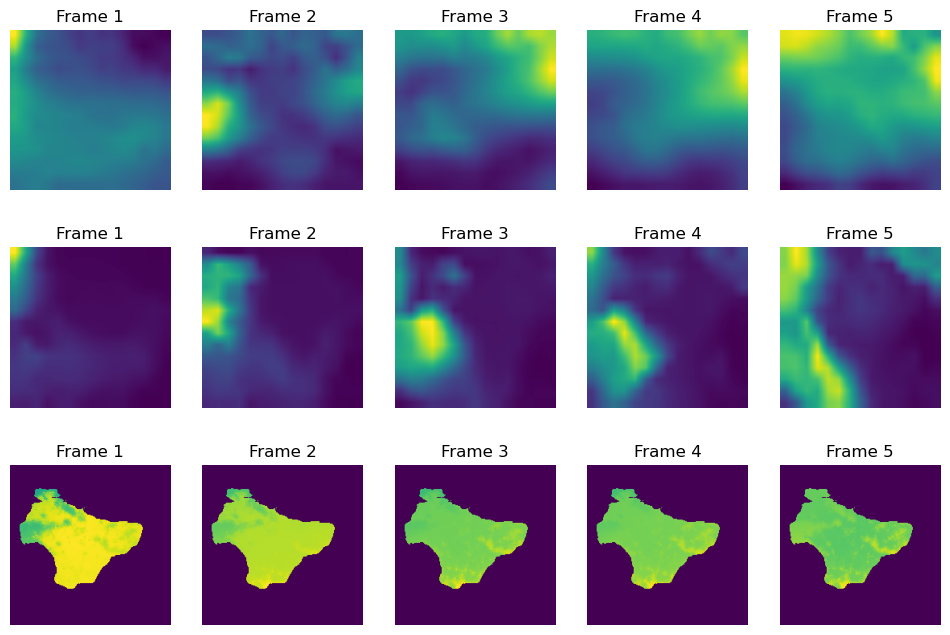

Target:  [11.1 11.2 19.7]


In [26]:
import matplotlib.pyplot as plt

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

# Plot each of the sequential images for one random data example.
np.random.seed(42)
# plot colmd channel
rand_sample = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
# plot mdens channel
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 1]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
# plot airnow channel
for idx, ax in enumerate(axes[2]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 2]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

## Model

In [12]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-25 15:46:14.245522: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 15:46:14.253552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745621174.263718   76031 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745621174.267145   76031 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 15:46:14.277265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [13]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 200, 200, 3))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(3,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

I0000 00:00:1745621175.401094   76031 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │         9,780 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       600,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 671,074 (2.56 MB)

 Trainable params: 671,074 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

## Train and test

In [14]:
seq.fit(X_train, y_train, batch_size=4, epochs=150)

Epoch 1/150


I0000 00:00:1745621178.242904   83087 service.cc:148] XLA service 0x5ecf567c3d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745621178.242924   83087 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-25 15:46:18.325112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745621178.600312   83087 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1745621179.179435   83087 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745621179.358073   83087 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745621179.716565  

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 14.2538

E0000 00:00:1745621189.696508   83088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745621189.874066   83088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745621190.212755   83088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745621190.387963   83088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745621190.955468   83088 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - loss: 14.1883
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 9.3867
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 6.5039
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 7.2315
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 6.0523
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 6.7188
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 6.0654
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 5.3945
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 5.5196
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 4.2685
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 5.2953
Epoch 12/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 5.7972
Epoch 13/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 5.5319
Epoch 14/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 5.3121
Epoch 15/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step

In [15]:
y_pred = seq.predict(X_test, verbose=0)
print(y_test.shape, y_pred.shape)

2025-04-25 15:58:31.146666: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,200,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,200,200]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,200,200]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-25 15:58:31.611831: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,200,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,200,200]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,200,200]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_label

(42, 3) (42, 3)


In [16]:
from skimage.metrics import mean_squared_error as mse

# hardcode for now
air_sensor_loc = ["North Holywood", "Los Angeles - N. Main Street", "Compton"]

def rmse(y_pred, y_test):
    return np.sqrt(mse(y_pred, y_test))

def nrmse(y_pred, y_test):
    return rmse(y_pred, y_test) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
#for i, loc in enumerate(list(AD.air_sens_loc.keys())):
for i, loc in enumerate(air_sensor_loc):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 15.97
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 144.90%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 2.36
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 15.31%

Frame 2 (Hour 2) All Locations - Raw RMSE: 1.70
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 12.32%

Frame 3 (Hour 3) All Locations - Raw RMSE: 3.47
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 25.22%

Frame 4 (Hour 4) All Locations - Raw RMSE: 1.37
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 9.65%

Frame 5 (Hour 5) All Locations

## RMSE results visualization


Visualizing model predictions vs actual values...


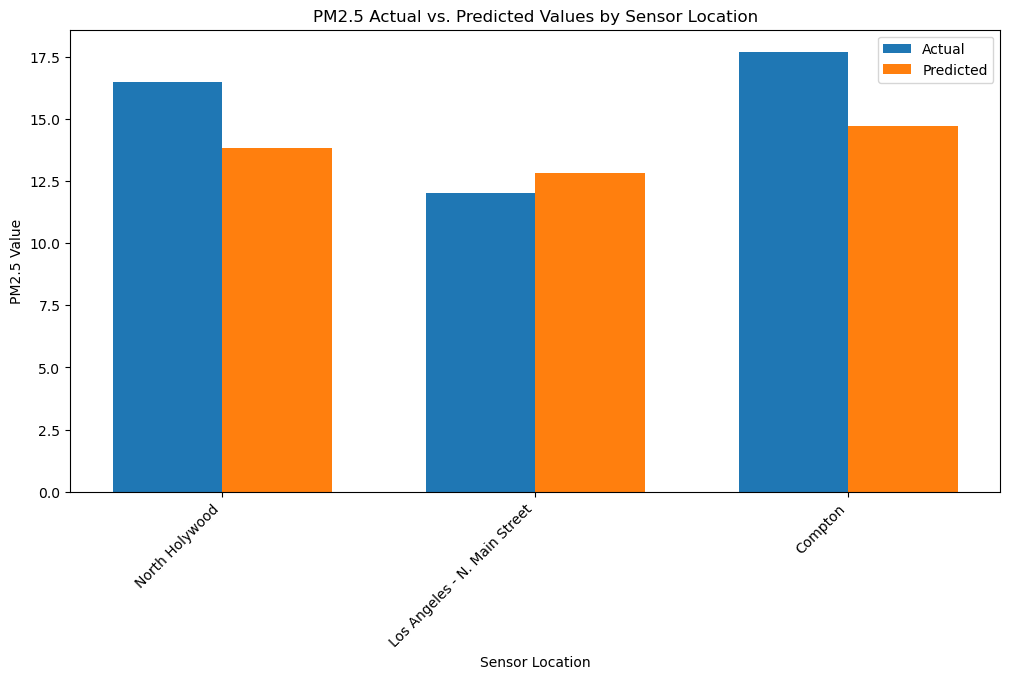

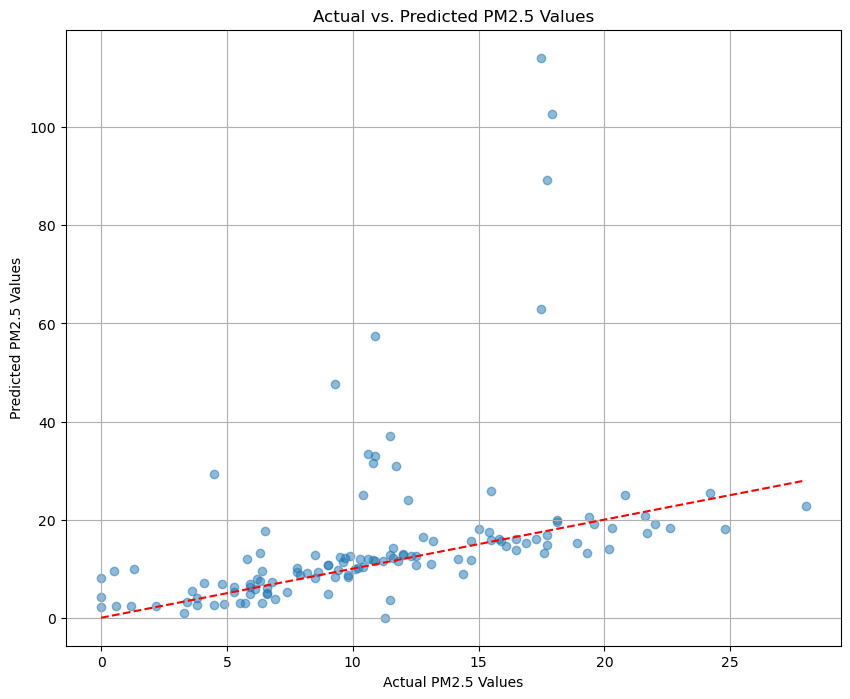

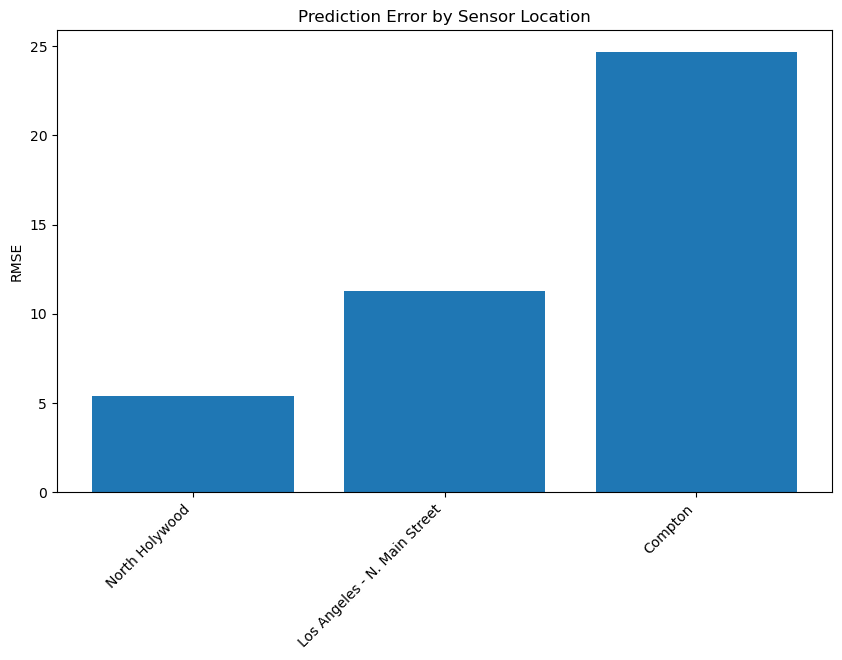

In [17]:
print("\nVisualizing model predictions vs actual values...")

# Choose the first test sample for consistent visualizations
sample_idx = 0

# Create a bar chart comparing predicted vs actual values for each sensor
fig, ax = plt.subplots(figsize=(12, 6))
#sensor_names = list(AD.air_sens_loc.keys())
sensor_names = air_sensor_loc
x = np.arange(len(sensor_names))
width = 0.35

true_vals = y_test[sample_idx]
pred_vals = y_pred[sample_idx]

rects1 = ax.bar(x - width/2, true_vals, width, label='Actual')
rects2 = ax.bar(x + width/2, pred_vals, width, label='Predicted')

ax.set_title('PM2.5 Actual vs. Predicted Values by Sensor Location')
ax.set_ylabel('PM2.5 Value')
ax.set_xlabel('Sensor Location')
ax.set_xticks(x)
ax.set_xticklabels(sensor_names, rotation=45, ha='right')
ax.legend()

#plt.tight_layout()
plt.show()

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.5)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')  # Perfect prediction line
plt.xlabel('Actual PM2.5 Values')
plt.ylabel('Predicted PM2.5 Values')
plt.title('Actual vs. Predicted PM2.5 Values')
plt.grid(True)
#plt.tight_layout()
plt.show()

# Compute error metrics for each sensor
error_by_sensor = []
for i, sensor in enumerate(sensor_names):
    error = rmse(y_pred[:, i], y_test[:, i])
    error_by_sensor.append(error)

# Create bar chart of errors by sensor
plt.figure(figsize=(10, 6))
plt.bar(sensor_names, error_by_sensor)
plt.ylabel('RMSE')
plt.title('Prediction Error by Sensor Location')
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()

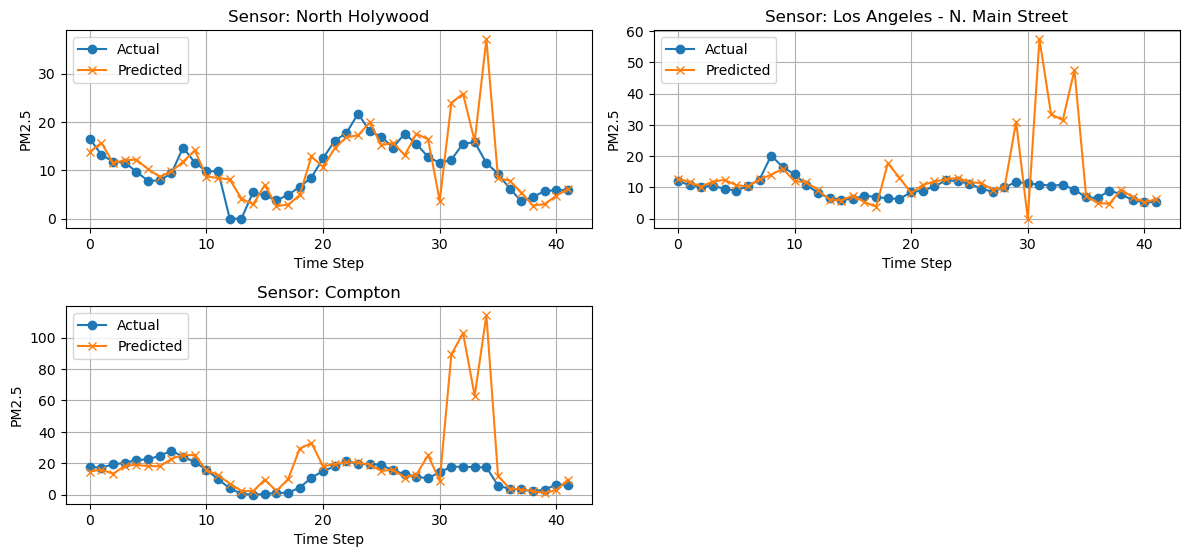

In [18]:
plt.figure(figsize=(12, 8))
#for i, sensor in enumerate(AD.air_sens_loc.keys()):
for i, sensor in enumerate(air_sensor_loc):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

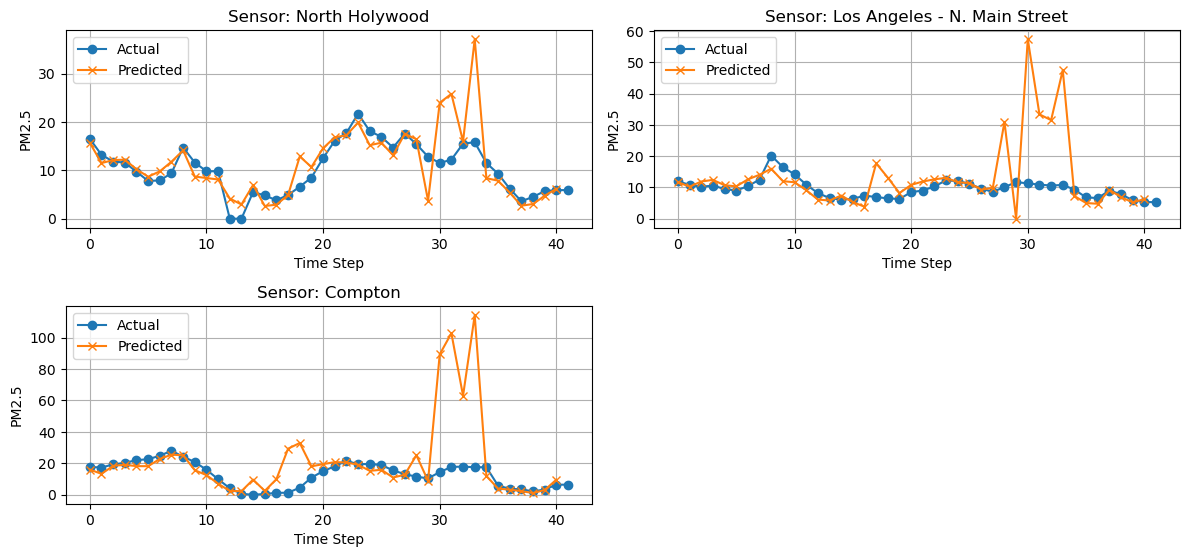

In [19]:
# check off by one
plt.figure(figsize=(12, 8))
#for i, sensor in enumerate(AD.air_sens_loc.keys()):
for i, sensor in enumerate(air_sensor_loc):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[1:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

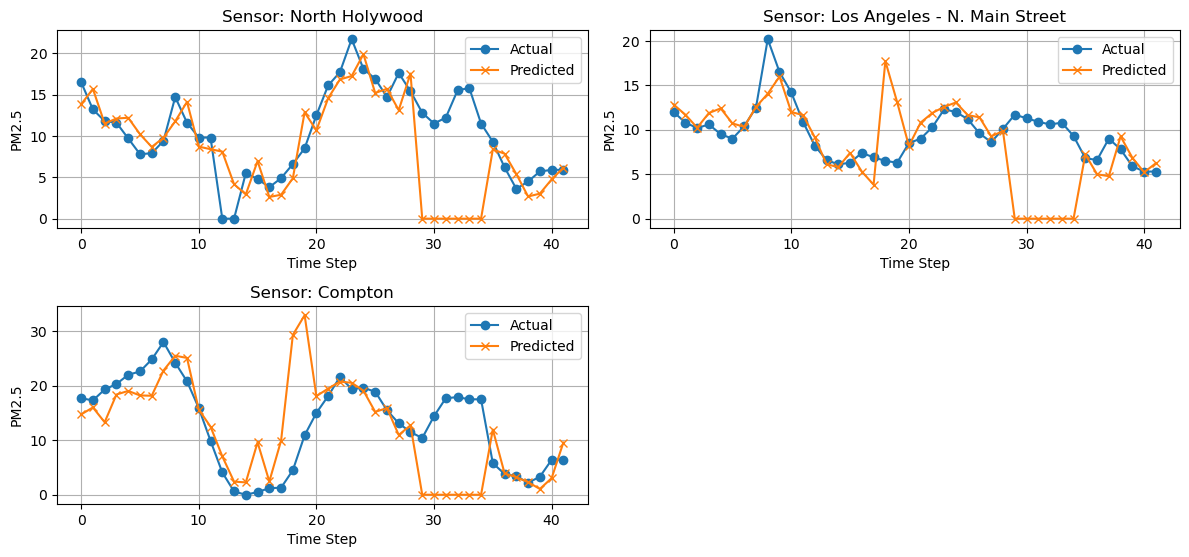

In [23]:
# cut outliers
plt.figure(figsize=(12, 8))
#for i, sensor in enumerate(AD.air_sens_loc.keys()):
y_pred_no_outliers = y_pred.copy()
y_pred_no_outliers[29:35] = 0.0
for i, sensor in enumerate(air_sensor_loc):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred_no_outliers[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

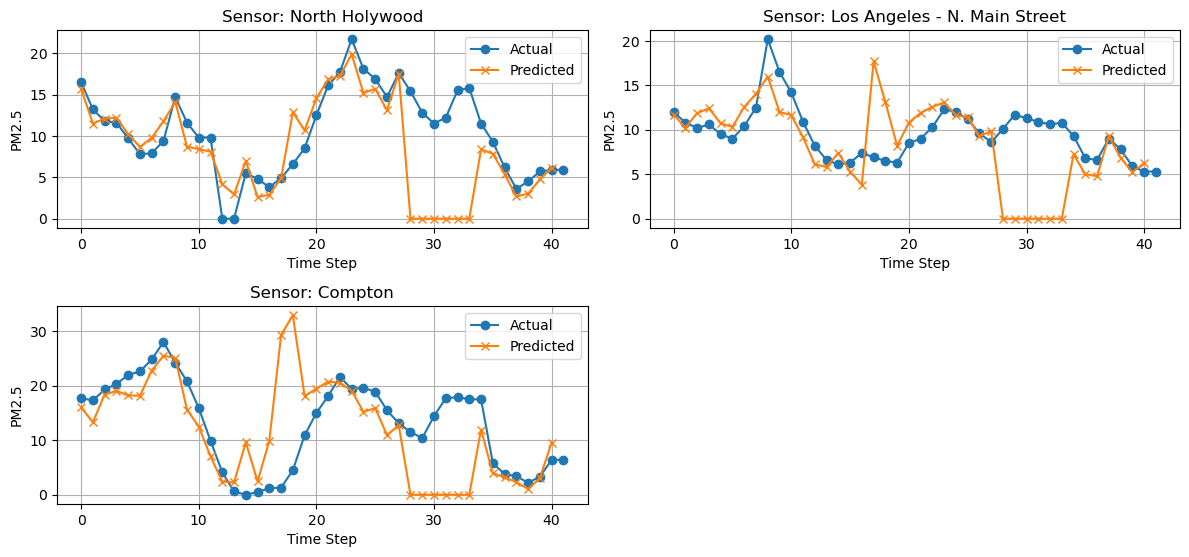

In [24]:
# check off by one + cut outliers
plt.figure(figsize=(12, 8))
#for i, sensor in enumerate(AD.air_sens_loc.keys()):
y_pred_no_outliers = y_pred.copy()
y_pred_no_outliers[29:35] = 0.0
for i, sensor in enumerate(air_sensor_loc):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred_no_outliers[1:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()